# 4. Find weights to apply to account for sample selection

The counts we found in [./3_servs_lf.ipynb](./3_servs_lf.ipynb) are much too low. Here we will try to understand the objects thrown away at each stage.

In [1]:
from herschelhelp_internal import git_version
print("This notebook was run with herschelhelp_internal version: \n{}".format(git_version()))
import datetime
print("This notebook was executed on: \n{}".format(datetime.datetime.now()))

This notebook was run with herschelhelp_internal version: 
017bb1e (Mon Jun 18 14:58:59 2018 +0100)
This notebook was executed on: 
2018-11-05 16:15:07.194247


In [2]:
import numpy as np
from astropy.table import Table

%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))

from astropy import units as u
from astropy.coordinates import SkyCoord

from herschelhelp_internal.masterlist import merge_catalogues, nb_merge_dist_plot, specz_merge

/opt/anaconda3/envs/herschelhelp_internal/lib/python3.6/site-packages/seaborn/apionly.py:6: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


In Gruppioni et al. (2017) they apply weights due to missing photometric redshifts in the application of the Vmax method

$$
\Phi (L,z) = \frac{1}{\Delta L} \sum_i \frac{1}{w_i V_{\textrm{max}, i}}
$$


There are various stages to the selection:

1. Survey selection. The object must be bright enough to be detected by at least one of the observing surveys.

2. Our detection criteria. We insist objects must have at least two optical and at least 2 near infrared detections.

3. Photometric redshift. Objects must have a redshift. What determines whether an object gets a redshift is not entirely understood.

4. XID+ fluxes. To pass to CIGALE the object must have at least two FIR fluxes with s/n greater than 5.

5. CIGALE fit.

First, lets look at the numbers.


In [3]:
#dmu = '/Users/rs548/GitHub/dmu_products/'
dmu = '/mnt/hedam/dmu_products/'
cat = Table.read(dmu + 'dmu32/dmu32_ELAIS-N1/data/ELAIS-N1_20171016.fits')

In [4]:
cat.colnames

['help_id',
 'field',
 'ra',
 'dec',
 'hp_idx',
 'ebv',
 'redshift',
 'zspec',
 'f_wfc_u',
 'ferr_wfc_u',
 'f_ap_wfc_u',
 'ferr_ap_wfc_u',
 'm_wfc_u',
 'merr_wfc_u',
 'm_ap_wfc_u',
 'merr_ap_wfc_u',
 'flag_wfc_u',
 'f_megacam_u',
 'ferr_megacam_u',
 'f_ap_megacam_u',
 'ferr_ap_megacam_u',
 'm_megacam_u',
 'merr_megacam_u',
 'm_ap_megacam_u',
 'merr_ap_megacam_u',
 'flag_megacam_u',
 'f_suprime_g',
 'ferr_suprime_g',
 'f_ap_suprime_g',
 'ferr_ap_suprime_g',
 'm_suprime_g',
 'merr_suprime_g',
 'm_ap_suprime_g',
 'merr_ap_suprime_g',
 'flag_suprime_g',
 'f_megacam_g',
 'ferr_megacam_g',
 'f_ap_megacam_g',
 'ferr_ap_megacam_g',
 'm_megacam_g',
 'merr_megacam_g',
 'm_ap_megacam_g',
 'merr_ap_megacam_g',
 'flag_megacam_g',
 'f_gpc1_g',
 'ferr_gpc1_g',
 'f_ap_gpc1_g',
 'ferr_ap_gpc1_g',
 'm_gpc1_g',
 'merr_gpc1_g',
 'm_ap_gpc1_g',
 'merr_ap_gpc1_g',
 'flag_gpc1_g',
 'f_wfc_g',
 'ferr_wfc_g',
 'f_ap_wfc_g',
 'ferr_ap_wfc_g',
 'm_wfc_g',
 'merr_wfc_g',
 'm_ap_wfc_g',
 'merr_ap_wfc_g',
 'flag_wf

In [5]:
total = len(cat)
photoz = np.sum(~np.isnan(cat['redshift']))
specz = np.sum(~np.isnan(cat['zspec']))
optnir_obs = np.sum(((cat['flag_optnir_obs'] == 3) 
          | (cat['flag_optnir_obs'] == 7)))
optnir_det = np.sum(((cat['flag_optnir_det'] == 3) 
          | (cat['flag_optnir_det'] == 7)))
cigale_dustlumin = np.sum(~np.isnan(cat['cigale_dustlumin']))

In [6]:
good = {}
for band in ['pacs_green', 'pacs_red', 'spire_250', 'spire_350', 'spire_500']:
    good[band] = (~np.isnan(cat['f_{}'.format(band)]) & 
                                   ~cat['flag_{}'.format(band)])
    good[band][good[band]] &= (cat[good[band]]['f_{}'.format(band)] /
                              cat[good[band]]['ferr_{}'.format(band)] >= 2)

In [7]:
combined_good = np.sum(list(good.values()), axis=0) >= 2
num_good = np.sum(combined_good)

In [8]:
any_xid = np.sum(np.sum(list(good.values()), axis=0) >= 1)

In [9]:
blind = Table.read(dmu + 'dmu22/dmu22_ELAIS-N1/data/dmu22_XID+SPIRE_ELAIS-N1_BLIND_Matched_MF.fits')

In [10]:
print(
"""
Total number: {}
Photometric redshifts: {}
Spectrographic redshifts: {}
observed in optical and nir:{}
Detected in optical and nir: {}
Any XID+: {}
Two or more XID+ fluxes with a S/N above two: {}
CIGALE dust luminosities: {}

Blind fluxes: {}
""".format(total, photoz, specz, optnir_obs, optnir_det, any_xid, num_good, cigale_dustlumin, len(blind))
)


Total number: 4026292
Photometric redshifts: 2714686
Spectrographic redshifts: 5109
observed in optical and nir:3431269
Detected in optical and nir: 463203
Any XID+: 101548
Two or more XID+ fluxes with a S/N above two: 51153
CIGALE dust luminosities: 49986

Blind fluxes: 34501



In [11]:
blind

HELP_ID,RA,Dec,F_SPIRE_250,FErr_SPIRE_250_u,FErr_SPIRE_250_l,F_SPIRE_350,FErr_SPIRE_350_u,FErr_SPIRE_350_l,F_SPIRE_500,FErr_SPIRE_500_u,FErr_SPIRE_500_l,Bkg_SPIRE_250,Bkg_SPIRE_350,Bkg_SPIRE_500,Sig_conf_SPIRE_250,Sig_conf_SPIRE_350,Sig_conf_SPIRE_500,Rhat_SPIRE_250,Rhat_SPIRE_350,Rhat_SPIRE_500,n_eff_SPIRE_250,n_eff_SPIRE_500,n_eff_SPIRE_350,Pval_res_250,Pval_res_350,Pval_res_500,flag_spire_250,flag_spire_350,flag_spire_500,F_BLIND_MF_SPIRE_250,FErr_BLIND_MF_SPIRE_250,F_BLIND_MF_SPIRE_350,FErr_BLIND_MF_SPIRE_350,F_BLIND_MF_SPIRE_500,FErr_BLIND_MF_SPIRE_500,r,P,RA_pix,Dec_pix,F_BLIND_pix_SPIRE,FErr_BLIND_pix_SPIRE,flag,field
,deg,deg,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy/Beam,mJy/Beam,mJy/Beam,mJy/Beam,mJy/Beam,mJy/Beam,,,,,,,,,,,,,mJy,mJy,mJy,mJy,mJy,mJy,,,deg,deg,mJy,mJy,,
bytes33,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bool,bool,bool,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes8
HELP_BLIND_J160632.875+532632.977,241.63697833849417,53.4424936064113,1076.3284,1076.8002,1075.2565,427.05466,427.24368,426.666,159.72685,163.28047,156.23094,-1.5558592,-2.4243228,-3.0628216,3.3583806,3.8439848,3.6612494,nan,nan,0.9989752,2000.0,2000.0,2000.0,1.0,1.0,0.023,True,True,False,1140.5062939199252,4.775354027588683,468.5655573859009,4.087799332594563,168.50649547655374,4.419515702525272,0.7910756530416875,1.0,241.63697833849417,53.4424936064113,998.8813286226596,4.665991720020079,0.0,ELAIS-N1
HELP_BLIND_J162125.844+560032.529,245.35768359048848,56.00903569669183,664.98486,665.04596,664.8602,290.6198,290.95413,289.9357,113.4069,116.6214,109.76138,-1.7619379,-2.8314667,-3.6850638,3.120625,3.5552156,3.4286942,nan,0.99888897,0.9990541,2000.0,2000.0,2000.0,1.0,0.977,0.0,True,True,False,739.7055387173003,4.344738560519794,311.95246556770326,4.315147464027572,120.88013799220789,4.158584047506172,0.791540035071294,1.0,245.3597031238259,56.00955128135834,702.7865838967327,4.208269112951256,0.0,ELAIS-N1
HELP_BLIND_J162142.463+550507.737,245.42692800683182,55.08548243993107,587.186,587.2036,587.14795,348.35855,348.39044,348.28958,181.8383,181.95042,181.59132,-2.0296905,-3.0494676,-4.122144,4.886088,3.9915822,3.165648,nan,nan,1.0003484,2000.0,2000.0,2000.0,1.0,1.0,1.0,True,True,True,647.6261258230762,4.0595903706872685,392.9120053055415,4.1260286274262015,212.29206330880584,4.7289235929105775,0.9189104969010979,1.0,245.42832976089494,55.08461993177872,531.3785923495558,4.0353948803353115,0.0,ELAIS-N1
HELP_BLIND_J160440.548+553408.377,241.16895166849534,55.56899355821793,351.0219,351.2573,350.5223,154.45348,155.92227,152.2044,55.500423,58.48213,52.47555,-2.2414632,-3.0505497,-3.998838,3.6281474,3.504178,2.8879697,0.99999666,0.99848294,1.0004892,2000.0,2000.0,2000.0,1.0,0.414,0.0,True,False,False,382.60466932485053,4.1673608927044565,164.5094457321369,4.223805456296819,57.10611860369097,4.219843249874001,0.8096007371789213,1.0,241.17038783975,55.5698473331343,390.0896460100279,4.0740517470418744,0.0,ELAIS-N1
HELP_BLIND_J161457.172+555221.809,243.73821494654106,55.8727246474237,480.51782,480.54697,480.45612,280.6323,280.74744,280.36774,129.12306,129.68927,127.9111,-2.0879714,-3.1434977,-4.460485,3.7134619,3.6111908,3.334691,nan,nan,0.9990281,2000.0,2000.0,2000.0,1.0,1.0,0.907,True,True,True,516.4442811120159,4.320671429225326,284.31131457502687,4.09436185982543,135.8254795098113,4.06230888317276,0.8442016852515221,1.0,243.73821494654106,55.8727246474237,388.2954806700044,4.2241126346089395,0.0,ELAIS-N1
HELP_BLIND_J162211.111+550253.624,245.54629376857181,55.04822891325986,380.147,383.476,376.7589,138.50343,139.2859,136.91702,48.70318,51.93736,45.277966,-2.0296905,-3.0494676,-4.122144,4.886088,3.9915822,3.165648,1.0005931,1.0011692,0.99931866,2000.0,2000.0,2000.0,1.0,0.223,0.0,True,False,False,389.0798730136472,4.24136125822

Text(0,0.5,'Number per bin')

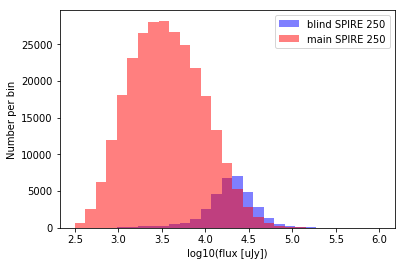

In [12]:
plt.hist(np.log10(1.e3*blind['F_SPIRE_250']), 
         bins=np.linspace(2.5, 6.0, num=30), color='b', alpha=0.5, 
         label = 'blind SPIRE 250')
plt.hist(np.log10(cat['f_spire_250'][~np.isnan(cat['f_spire_250'])]), 
         bins=np.linspace(2.5, 6.0, num=30), color='r', alpha=0.5, 
         label = 'main SPIRE 250')
plt.legend()
plt.xlabel('log10(flux [uJy])')
plt.ylabel('Number per bin')

Text(0,0.5,'Number per bin')

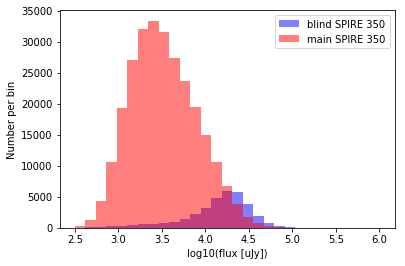

In [13]:
plt.hist(np.log10(1.e3*blind['F_SPIRE_350']), 
         bins=np.linspace(2.5, 6.0, num=30), color='b', alpha=0.5, 
         label = 'blind SPIRE 350')
plt.hist(np.log10(cat['f_spire_350'][~np.isnan(cat['f_spire_350'])]), 
         bins=np.linspace(2.5, 6.0, num=30), color='r', alpha=0.5, 
         label = 'main SPIRE 350')
plt.legend()
plt.xlabel('log10(flux [uJy])')
plt.ylabel('Number per bin')

Text(0,0.5,'Number per bin')

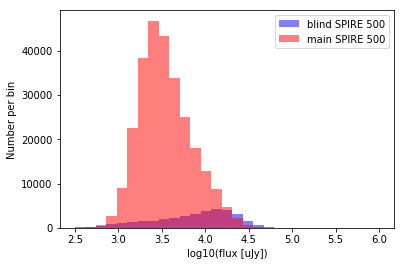

In [14]:
plt.hist(np.log10(1.e3*blind['F_SPIRE_500']), 
         bins=np.linspace(2.5, 6.0, num=30), color='b', alpha=0.5, 
         label = 'blind SPIRE 500')
plt.hist(np.log10(cat['f_spire_500'][~np.isnan(cat['f_spire_500'])]), 
         bins=np.linspace(2.5, 6.0, num=30), color='r', alpha=0.5, 
         label = 'main SPIRE 500')
plt.legend()
plt.xlabel('log10(flux [uJy])')
plt.ylabel('Number per bin')

/opt/anaconda3/envs/herschelhelp_internal/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


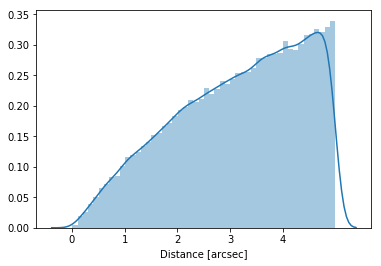

In [15]:
nb_merge_dist_plot(
    SkyCoord(cat['ra'], cat['dec']),
    SkyCoord(blind['RA'], blind['Dec'])
)

/opt/anaconda3/envs/herschelhelp_internal/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


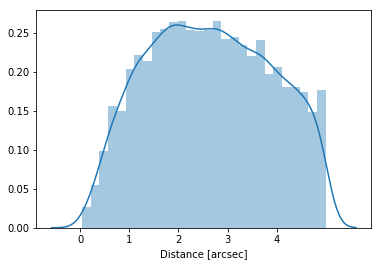

In [16]:
nb_merge_dist_plot(
    SkyCoord(cat['ra'][combined_good], cat['dec'][combined_good]),
    SkyCoord(blind['RA'], blind['Dec'])
)

In [17]:
good_cat = cat[combined_good]

In [18]:
# Given the graph above, we use 0.8 arc-second radius
merge = merge_catalogues(good_cat, blind, "RA", "Dec", radius=5.0*u.arcsec)

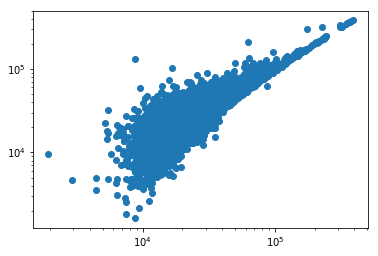

In [19]:
plt.scatter(merge['f_spire_250'], 1.e3*merge['F_SPIRE_250'])
plt.plot([1.e4,1.e5],[1.e4,1.e5], color='r')
plt.yscale('log')
plt.xscale('log')